In [1]:
from netCDF4 import Dataset  # http://code.google.com/p/netcdf4-python/
####################you will need to change some paths here!#####################
#list of input files
filename_cpr='f:/data/eddy/CPR_data/All CPR Sample catalogue.xlsx'
filename_northpac_eddies='F:/data/eddy/aviso/eddy_trajectory_19930101_20170106_north_pacific.nc'
filename_cpr_eddy='F:/data/eddy/collocated_data/eddy_cpr_data_north_pacific.nc'
filename_eddy='F:/data/eddy/collocated_data/eddy_ranking_data_north_pacific.nc'
#output files
filename_cpr_expanded='f:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info2.xlsx'
filename_cpr_expanded_netcdf='f:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info2.nc'
#################################################################################

In [2]:
import datetime as dt
import pandas
import matplotlib as mpl
import openpyxl
from mpl_toolkits.basemap import Basemap
import matplotlib.pyplot as plt
import numpy as np
from math import cos, radians

In [3]:
#read in CPR data excell file using pandas library
df = pandas.read_excel(filename_cpr)
#print the column names
print(df.columns)
#get the values for a given column
cpr_sample_id = df['Sample ID'].values
cpr_sample_day = df['day'].values
cpr_sample_month = df['month'].values
cpr_sample_year = df['year'].values
cpr_sample_lat = df['lat'].values
cpr_sample_lon = df['Long'].values
cpr_sample_proc = df['Already processed?'].values
print(len(cpr_sample_proc))

Index(['Sample ID', 'day', 'month', 'year', 'lat', 'Long',
       'Already processed?'],
      dtype='object')
23306


In [4]:
min(cpr_sample_lon[cpr_sample_lon<0]),max(cpr_sample_lon[cpr_sample_lon<0]),min(cpr_sample_lat),max(cpr_sample_lat)

(-179.935, -118.37075, 33.48765, 61.151666666666664)

In [5]:
import xarray as xr
import numpy as np
from scipy.interpolate import RectBivariateSpline

#get bathymetry from ETOPO1
fname_topo = 'F:/data/topo/ETOPO1_Ice_g_gmt4.grd'
ds_topo = xr.open_dataset(fname_topo)
x = ds_topo.x  #21601
y = ds_topo.y   #10801
topo = ds_topo.z  #(10801, 21601)


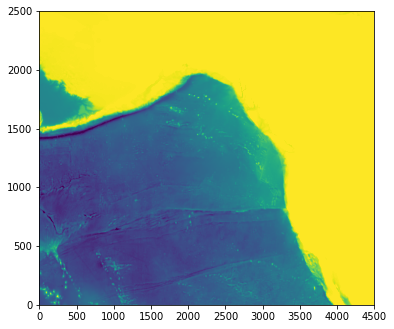

In [6]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
im = ax1.imshow(ds_topo.z[7000:9500,0:4500], interpolation='bilinear',vmin=-7000.0, vmax=1.0,aspect='auto',origin='lower')
plt.show()


In [7]:
cpr_sample_depth_exact=[0]*len(cpr_sample_lon)
for i in range(0,len(cpr_sample_lon)):
    lon = cpr_sample_lon[i]
    lat = cpr_sample_lat[i]
    idx = (abs(lon - ds_topo.x.values)).argmin()  #find the closest point
    idy = (abs(lat - ds_topo.y.values)).argmin()  #find the closest point
    cpr_sample_depth_exact[i]=ds_topo.z.values[idy,idx]
#add this data to the df panda that contains the excel data
df['ETOPO_depth (m) nearest neighbor']=cpr_sample_depth_exact

In [8]:
cpr_sample_depth=[0]*len(cpr_sample_lon)
for i in range(0,len(cpr_sample_lon)):
    lon = cpr_sample_lon[i]
    lat = cpr_sample_lat[i]
    idx = (abs(lon - x.values)).argmin()  #find the closest point
    if x.values[idx]<lon:
        iini = idx - 1
        ifin = idx + 3
    else:
        iini = idx - 2
        ifin = idx + 2
    idx2 = (abs(lat - y.values)).argmin()
    if y.values[idx2]<lat:
        jini =  idx2 - 1
        jfin =  idx2 + 3
    else:
        jini =  idx2 - 2
        jfin =  idx2 + 2       
    assert (iini >= 0) or (iini <= len(x)) or \
        (jini >= 0) or (jini <= len(y)), \
        "Sorry not ready to handle too close to boundaries" 
    if ifin>=21600:
        tem1 = x.values[iini:]-360
        tem2 = x.values[1:ifin-len(x)+1]
        x_in = np.append(tem1,tem2,0)
        y_in = y.values[jini:jfin]
        tem1 = topo.values[jini:jfin,iini:]
        tem2 = topo.values[jini:jfin,1:ifin-len(x)+1]
        z_in = np.append(tem1,tem2, axis=1)
    else:    
        x_in = x.values[iini:ifin]
        y_in = y.values[jini:jfin]
        z_in = topo.values[jini:jfin, iini:ifin]
    interpolator = RectBivariateSpline(x_in, y_in, z_in.T)
    cpr_sample_depth[i]=interpolator(lon, lat)[0][0]
df['ETOPO_depth (m) interp']=cpr_sample_depth

In [9]:
#plt.imshow(sst[0,:,:]-273.15, cmap=plt.cm.jet, vmin = -2, vmax = 30, origin='lower')
#plt.colorbar()
#plt.show()

In [10]:
#testing of topo and rectbivariate spline
#get SST from CMC
#test rectbivariatespline
minlon=-179.
maxlon=-100.
minlat=0
maxlat=60
print(minlon,maxlon,minlat,maxlat)
ix=int(abs(maxlon-minlon))*10
iy=int(abs(maxlat-minlat))*10
print(ix,iy)
test_depth=np.ones((ix,iy))
test_depth2=np.ones((ix,iy))
for i in range(0,ix):
    for j in range(0,iy):
        lon = minlon+i/10
        lat = minlat+j/10
        idx = (abs(lon - x.values)).argmin()  #find the closest point
        if x.values[idx]<lon:
            iini = idx - 1
            ifin = idx + 3
        else:
            iini = idx - 2
            ifin = idx + 2
        idx2 = (abs(lat - y.values)).argmin()
        if y.values[idx2]<=lat:
            jini =  idx2 - 2
            jfin =  idx2 + 2
        else:
            jini =  idx2 - 1
            jfin =  idx2 + 3       
        if ifin>=21600:
            tem1 = x.values[iini:]-360
            tem2 = x.values[1:ifin-len(x)+1]
            x_in = np.append(tem1,tem2,0)
            y_in = y.values[jini:jfin]
            tem1 = topo.values[jini:jfin,iini:]
            tem2 = topo.values[jini:jfin,1:ifin-len(x)+1]
            z_in = np.append(tem1,tem2, axis=1)
        else:    
            x_in = x.values[iini:ifin]
            y_in = y.values[jini:jfin]
            z_in = topo.values[jini:jfin, iini:ifin]
        interpolator = RectBivariateSpline(x_in, y_in, z_in.T)
        test_depth[i,j]=interpolator(lon, lat)[0][0]
        test_depth2[i,j]=topo.values[idx2,idx]

-179.0 -100.0 0 60
790 600


In [11]:
#get sst/wind from ccmc
dir_cmc='F:/data/sst/cmc/CMC0.2deg/v2/'
dir_cmc_clim='F:/data/sst/cmc/CMC0.2deg/v2/climatology/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
ilen_cpr=len(cpr_sample_proc)
cpr_sample_jday=[0] * (ilen_cpr)
cpr_sample_sst=[0] * (ilen_cpr)
cpr_sample_sst_clim=[0] * (ilen_cpr)
print(ilen_cpr)
for index in range(0,ilen_cpr):
   # if int(index/500)*500==index:
   #     print(index,ilen_cpr)

    lon = cpr_sample_lon[i]
    lat = cpr_sample_lat[i]

    tem_time = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index])
    tt = tem_time.timetuple()
    cpr_sample_jday[index]=tt.tm_yday
       
    syr=str(cpr_sample_year[index]).zfill(4)
    smon=str(cpr_sample_month[index]).zfill(2)
    sdym=str(cpr_sample_day[index]).zfill(2)
    sjdy=str(cpr_sample_jday[index]).zfill(3)

    fname_tem=syr + smon + sdym + '120000-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'
    cmc_filename = dir_cmc + syr + '/' + sjdy + '/' + fname_tem
    if tem_time.timetuple().tm_yday==366:
        sjdy = '365'
    cmc_clim_filename = dir_cmc_clim + 'clim1993_2016' + sjdy + '-CMC-L4_GHRSST-SSTfnd-CMC0.2deg-GLOB-v02.0-fv02.0.nc'

 #   print(cmc_filename)
 #   print(cmc_clim_filename)
    nc_fid = Dataset(cmc_filename, 'r')
    nc_fid2 = Dataset(cmc_clim_filename, 'r')
    if index==0:
        lons = nc_fid.variables['lon'][:]
        lats = nc_fid.variables['lat'][:]
    idx = (abs(lon - lons)).argmin()  #find the closest point
    idy = (abs(lat - lats)).argmin()

    sst = nc_fid.variables['analysed_sst'][0,idy,idx]
    sst_clim = nc_fid2.variables['sst'][0,idy,idx]
    nc_fid.close()
    nc_fid2.close()
    #print(sst.shape,sst2.shape) 1,901,1800
    cpr_sample_sst[index]=sst
    cpr_sample_sst_clim[index]=sst_clim
df['SST CMC 2.0']=cpr_sample_sst
df['SST Climatology CMC 2.0']=cpr_sample_sst_clim
          

23306


In [12]:
#get sst/wind from ccmc
dir_cmc='F:/data/sst/cmc/CMC0.2deg/v2/'
dir_cmc_clim='F:/data/sst/cmc/CMC0.2deg/v2/climatology/'
dir_ccmp='F:/data/sat_data/ccmp/v02.0/Y'
ilen_cpr=len(cpr_sample_proc)
cpr_sample_uwnd=[0] * (ilen_cpr)
cpr_sample_vwnd=[0] * (ilen_cpr)
cpr_sample_uwnd_clim=[0] * (ilen_cpr)
cpr_sample_vwnd_clim=[0] * (ilen_cpr)
print(ilen_cpr)
for index in range(0,ilen_cpr):
   # if int(index/500)*500==index:
   #     print(index,ilen_cpr)

    lon = cpr_sample_lon[i]
    lat = cpr_sample_lat[i]

    tem_time = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index])
    tt = tem_time.timetuple()
    #cpr_sample_jday[index]=tt.tm_yday
       
    syr=str(cpr_sample_year[index]).zfill(4)
    smon=str(cpr_sample_month[index]).zfill(2)
    sdym=str(cpr_sample_day[index]).zfill(2)
    sjdy=str(cpr_sample_jday[index]).zfill(3)

    sjdy=str(cpr_sample_jday[index]).zfill(3)
    fname_tem='/CCMP_Wind_Analysis_' + syr + smon + sdym + '_V02.0_L3.0_RSS.nc'
    ccmp_filename = dir_ccmp + syr + '/M' + smon + fname_tem      
    if tem_time.timetuple().tm_yday==366:
        sjdy = '365'
    ccmp_clim_filename='F:/data/sat_data/ccmp/v02.0/clim/ccmp_daily_clim_' + sjdy +'.nc'
   # print(ccmp_filename)
   # print(ccmp_clim_filename)
    nc_fid = Dataset(ccmp_filename, 'r')
    nc_fid2 = Dataset(ccmp_clim_filename, 'r')                      
    if index==0:
        lats = nc_fid.variables['latitude'][:]
        lons = nc_fid.variables['longitude'][:]
    idx = (abs(lon - lons)).argmin()  #find the closest point
    idy = (abs(lat - lats)).argmin()
    tem = nc_fid.variables['uwnd'][:,idy,idx]
    uwnd = np.mean(tem,axis=0)
    tem = nc_fid.variables['vwnd'][:,idy,idx]
    vwnd = np.mean(tem,axis=0)
    uwnd_clim = nc_fid2.variables['av_u'][idy,idx]
    vwnd_clim = nc_fid2.variables['av_v'][idy,idx]
    nc_fid.close()
    nc_fid2.close()
    #print(uwnd.shape,uwnd_clim.shape) 628,1440
    cpr_sample_uwnd[index]=uwnd
    cpr_sample_vwnd[index]=vwnd
    cpr_sample_uwnd_clim[index]=uwnd_clim
    cpr_sample_vwnd_clim[index]=vwnd_clim
df['U_wnd CCMC m/s']=cpr_sample_uwnd
df['V_wnd CCMC m/s']=cpr_sample_vwnd
df['Climatology U_wnd CCMC m/s']=cpr_sample_uwnd_clim
df['Climatology V_wnd CCMC m/s']=cpr_sample_vwnd_clim
           
           


23306


In [13]:
dir_oscar='f:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_oscar_clim='f:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'

ilen_cpr=len(cpr_sample_proc)
cpr_sample_ucur=[0] * (ilen_cpr)
cpr_sample_vcur=[0] * (ilen_cpr)
cpr_sample_ucur_clim=[0] * (ilen_cpr)
cpr_sample_vcur_clim=[0] * (ilen_cpr)
print(ilen_cpr)
for index in range(0,ilen_cpr):
    lon = cpr_sample_lon[index]
    lat = cpr_sample_lat[index]
    #print('cpr lon lat:', lon,lat)

    tem_time = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index])
    tt = tem_time.timetuple()
    cpr_sample_jday[index]=tt.tm_yday

    syr=str(cpr_sample_year[index]).zfill(4)
    smon=str(cpr_sample_month[index]).zfill(2)
    sdym=str(cpr_sample_day[index]).zfill(2)
    sjdy=str(cpr_sample_jday[index]).zfill(3)

    oscar_filename = dir_oscar + 'oscar_vel' + syr + '.nc'
    if tem_time.timetuple().tm_yday==366:
        sjdy = '365'
    oscar_clim_filename = dir_oscar_clim + sjdy + '_oscar_v2009_1993_2016_climatology_original_projection.nc'

    nc_fid = Dataset(oscar_filename, 'r')
    nc_fid2 = Dataset(oscar_clim_filename, 'r')
    if index==0:
        lons = nc_fid.variables['longitude'][:]
        lons = ((lons - 180) % 360) - 180  #make -180 to 180 rather than 0 360
        lats = nc_fid.variables['latitude'][:]
    idx = (abs(lon - lons)).argmin()  #find the closest point
    idy = (abs(lat - lats)).argmin()
    time = nc_fid.variables['time'][:] #long_name = 'Day since 1992-10-05 00:00:00'
    tem = np.ma.array(time,fill_value = -999)
    ishape = tem.shape
    ilen = ishape[0]
    oscar_date = [0]*ilen
    for i in range(0,ilen):
        oscar_date[i] = dt.datetime(1992,10,5) + dt.timedelta(days = float(tem[i]))
    cpr_date_delta = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index]) - dt.datetime(1992,10,5) 
    tem_diff = tem - cpr_date_delta.days
    ii=np.argwhere(tem_diff>0)
    i1=int(ii[0]-1)
    i2=int(i1+1)
    f1=1-abs(tem_diff[i1])/5.
    f2=1-f1
    uvel1 = nc_fid.variables['u'][i1:i2+1,0,idy,idx]
    uvel = uvel1[0]*f1 + uvel1[1]*f2
    uvel_clim = nc_fid2.variables['u'][idy,idx]
    vvel1 = nc_fid.variables['v'][i1:i2+1,0,idy,idx]
    vvel = vvel1[0]*f1 + vvel1[1]*f2
    vvel_clim = nc_fid2.variables['v'][idy,idx]
    nc_fid.close()
    nc_fid2.close()
    cpr_sample_ucur[index]=uvel
    cpr_sample_vcur[index]=vvel
    cpr_sample_ucur_clim[index]=uvel_clim
    cpr_sample_vcur_clim[index]=vvel_clim
df['U_cur oscar m/s']=cpr_sample_ucur
df['V_cur oscar m/s']=cpr_sample_vcur
df['Climatology U_cur oscar m/s']=cpr_sample_ucur_clim
df['Climatology V_cur oscar m/s']=cpr_sample_vcur_clim


23306


In [14]:
print(cpr_sample_sst[8:30])
print(cpr_sample_sst_clim[8:30])

[281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.84, 281.85]
[masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+36,
            dtype=float32), masked_array(data=282.50518798828125,
             mask=False,
       fill_value=9.96921e+

In [16]:
print(len(cpr_sample_ucur_clim),len(cpr_sample_vcur_clim))
#tt=ma.getdata(cpr_sample_ucur)
#where_are_NaNs = isnan(tt)
#tt[where_are_NaNs] = -999
#print(cpr_sample_ucur[1:10])
#print(tt[1:10])
data = np.ma.filled(cpr_sample_ucur, np.nan)
#data = np.array(cpr_sample_ucur, copy=False)
print(data[1:10])
#data[isnan(data)] = -999
print(data[1:10])

23306 23306
[-0.02271899 -0.023138   -0.05050472 -0.06304778 -0.06166632 -0.06166632
 -0.04573255 -0.04573255         nan]
[-0.02271899 -0.023138   -0.05050472 -0.06304778 -0.06166632 -0.06166632
 -0.04573255 -0.04573255         nan]


C:\Users\gentemann\Anaconda3\lib\site-packages\numpy\ma\core.py:640: UserWarning: Warning: converting a masked element to nan.
  return np.array(a)


In [17]:
 from copy import copy
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib.mlab as mlab
palette = copy(plt.cm.jet)
palette.set_over('r', 1.0)
palette.set_under('g', 1.0)
palette.set_bad(alpha = 0.0)


dir_oscar='f:/data/sat_data/oscar/L4/oscar_third_deg/'
dir_oscar_clim='f:/data/sat_data/oscar/L4/oscar_third_deg/climatology/'




TypeError: tuple indices must be integers or slices, not tuple

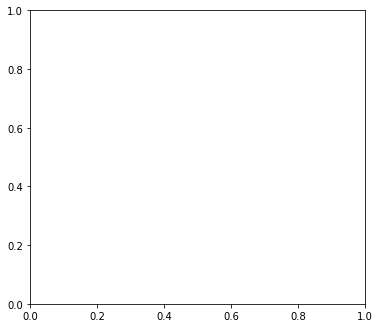

In [18]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
        # plot using 'continuous' color map
im = ax1.imshow(tt[62,0,:,:], interpolation='bilinear',cmap=palette,norm=colors.Normalize(vmin=-1.0, vmax=1.0),aspect='auto',origin='upper')
                        #extent=[x0, x1, y0, y1])
plt.show()

In [19]:
f = Dataset(filename_northpac_eddies,'r')
#tempgrp = f.createGroup('Eddy_data')
lons_eddy = f.variables['Longitude'][:]
lats_eddy = f.variables['Latitude'][:]
time_eddy = f.variables['time'][:]
amplitude_eddy = f.variables['amplitude'][:]
speed_average_eddy = f.variables['speed_average'][:]
speed_radius_eddy = f.variables['speed_radius'][:]
cyclonic_type_eddy = f.variables['cyclonic_type'][:]
track_eddy = f.variables['track'][:]
track_days_eddy = f.variables['track_total_days'][:]
observation_number_eddy = f.variables['observation_number'][:]
year_eddy = f.variables['year'][:]
idayjl_eddy = f.variables['idayjl'][:]
f.close()
print(len(idayjl_eddy))
print(filename_northpac_eddies)

1514261
F:/data/eddy/aviso/eddy_trajectory_19930101_20170106_north_pacific.nc


In [20]:
#read cpr_eddy info
f = Dataset(filename_cpr_eddy,'r') 
#tempgrp = nc_fid.groups['CPR_data']
save_eddy_index = f.variables['save_eddy_index'][:]
save_eddy_distance = f.variables['save_eddy_distance'][:]  
save_eddy_radius = f.variables['save_eddy_radius'][:]
cpr_dist_from_land = f.variables['cpr_dist_from_land'][:]
f.close()
print(min(save_eddy_index),max(save_eddy_index))
print(len(save_eddy_index))


0 1512583
23306


In [21]:
#read eddy ranking info
f = Dataset(filename_eddy,'r') 
print(filename_eddy)
tempgrp = f.groups['eddy_data']
cpr_unique_eddy_collocations = tempgrp.variables['cpr_unique_eddy_collocations'][:] #'eddy number of cpr collocations'
cpr_unique_eddy = tempgrp.variables['cpr_unique_eddy'][:]  #unique eddy track id
cpr_unique_eddy_index_cpr = tempgrp.variables['cpr_unique_eddy_index_cpr'][:] #cpr index for eddy id
f.close()
print(min(cpr_unique_eddy_collocations),max(cpr_unique_eddy_collocations))
print(len(cpr_unique_eddy_collocations))

F:/data/eddy/collocated_data/eddy_ranking_data_north_pacific.nc
1 192
1263


In [22]:
#add eddy info to all cpr data and output into a netcdf and excel file
print(len(save_eddy_index))
ilen=len(save_eddy_index) #ilen=len(save_eddy_index)
cpr_eddy_data_distance=[0]*ilen
cpr_eddy_data_radius=[0]*ilen
cpr_eddy_data_distance_from_land=[0]*ilen
cpr_eddy_data_lons=[0]*ilen
cpr_eddy_data_lats=[0]*ilen
cpr_eddy_data_time=[0]*ilen
cpr_eddy_data_amplitude=[0]*ilen
cpr_eddy_data_speed_average=[0]*ilen
cpr_eddy_data_speed_radius=[0]*ilen
cpr_eddy_data_speed_radius_deg=[0]*ilen
cpr_eddy_data_cyclonic_type=[0]*ilen
cpr_eddy_data_track_id=[0]*ilen
cpr_eddy_data_total_days=[0]*ilen
cpr_eddy_data_ob_num=[0]*ilen
cpr_eddy_data_year=[0]*ilen
cpr_eddy_data_idyjl=[0]*ilen

for index in range(0,ilen):
    index_eddy=save_eddy_index[index]
    cpr_eddy_data_distance[index]=save_eddy_distance[index]
    cpr_eddy_data_distance_from_land[index]=cpr_dist_from_land[index]
    cpr_eddy_data_radius[index]=save_eddy_radius[index]
    cpr_eddy_data_lons[index]=lons_eddy[index_eddy]
    cpr_eddy_data_lats[index]=lats_eddy[index_eddy]
    cpr_eddy_data_time[index]=time_eddy[index_eddy]
    cpr_eddy_data_amplitude[index]=amplitude_eddy[index_eddy]
    cpr_eddy_data_speed_average[index]=speed_average_eddy[index_eddy]
    cpr_eddy_data_speed_radius[index]=speed_radius_eddy[index_eddy]
    cpr_eddy_data_speed_radius_deg[index]=speed_radius_eddy[index_eddy]*cos(radians(lats_eddy[index_eddy]))/111.0
    cpr_eddy_data_cyclonic_type[index]=cyclonic_type_eddy[index_eddy]
    cpr_eddy_data_track_id[index]=track_eddy[index_eddy]
    cpr_eddy_data_total_days[index]=track_days_eddy[index_eddy]
    cpr_eddy_data_ob_num[index]=observation_number_eddy[index_eddy]
    cpr_eddy_data_year[index]=year_eddy[index_eddy]
    cpr_eddy_data_idyjl[index]=idayjl_eddy[index_eddy]

print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])


23306
101.72 0.7691804081094831


In [23]:
#find how many times eddy is sampled by CPR data
#ONLY include crossings whre distance is less than radius

ilen_cpr=len(cpr_sample_id)
ilen_id=max(cpr_eddy_data_track_id)
proc_cpr=[0]*ilen
num_cross=[0]*ilen
test_id=[0]*(ilen_id+1)
print(ilen_id,ilen_cpr)

#here set proc array to 1 where distance > radius  
#when cpr is too far away from eddy it won't count as a crossing
for i in range(0,ilen):
    if cpr_eddy_data_distance[i]>cpr_eddy_data_radius[i]:
        proc_cpr[i]=1

for i in range(0,ilen):
    test_yr=[0]*2020
    if proc_cpr[i]==1:
        continue
    track_id=cpr_eddy_data_track_id[i]
    test_id[track_id]=0
    iyr=cpr_sample_year[i]
    test_yr[iyr]=1
    proc_cpr[i]=1
    for j in range(i,ilen):
        if proc_cpr[j]==1:
            continue
        track_id2=cpr_eddy_data_track_id[j]
        if track_id2==track_id:
            iyr=cpr_sample_year[j]
            test_yr[iyr]=1
            proc_cpr[j]=1
    test_id[track_id]=sum(test_yr)
    #print(track_id,sum(test_yr))
for i in range(0,ilen):
    track_id=cpr_eddy_data_track_id[i]
    num_cross[i]=test_id[track_id]
    

271948 23306


In [24]:
import numpy.ma as ma
from numpy import *

#remove masked values from data
data = np.ma.filled(cpr_sample_ucur, np.nan)
data[isnan(data)] = -9999
cpr_sample_ucur2=data

data = np.ma.filled(cpr_sample_vcur, np.nan)
data[isnan(data)] = -9999
cpr_sample_vcur2=data

data = np.ma.filled(cpr_sample_ucur_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_ucur_clim2=data

data = np.ma.filled(cpr_sample_vcur_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_vcur_clim2=data

data = np.ma.filled(cpr_sample_sst, np.nan)
data[isnan(data)] = -9999
cpr_sample_sst2=data

data = np.ma.filled(cpr_sample_sst_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_sst_clim2=data

data = np.ma.filled(cpr_sample_uwnd, np.nan)
data[isnan(data)] = -9999
cpr_sample_uwnd2=data

data = np.ma.filled(cpr_sample_uwnd_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_uwnd_clim2=data

data = np.ma.filled(cpr_sample_vwnd, np.nan)
data[isnan(data)] = -9999
cpr_sample_vwnd2=data

data = np.ma.filled(cpr_sample_vwnd_clim, np.nan)
data[isnan(data)] = -9999
cpr_sample_vwnd_clim2=data


C:\Users\gentemann\Anaconda3\lib\site-packages\numpy\ma\core.py:640: UserWarning: Warning: converting a masked element to nan.
  return np.array(a)


In [25]:
#print(shape(df))
#print(shape(cpr_sample_jday))
#df_time=[0] * (ilen_cpr)
#print(ilen_cpr)
#for index in range(0,ilen_cpr):
#    df_time[index] = dt.datetime(cpr_sample_year[index],cpr_sample_month[index],cpr_sample_day[index])
#df_vars=['Sample ID','day','month','year','lat','lon','already processed?','ETOPO_depth (m) nearest neighbor','ETOPO_depth (m) interp','SST CMC 2.0','SST Climatology CMC 2.0','U_wnd CCMC m/s','V_wnd CCMC m/s','Climatology U_wnd CCMC m/s','Climatology V_wnd CCMC m/s','U_cur oscar m/s','V_cur oscar m/s','Climatology U_cur oscar m/s','Climatology V_cur oscar m/s']

In [26]:
#print(shape(df_time))
#print(shape(df_vars))
#print(type(df_time))

In [27]:
#type(df)
#print(type(df))
#print(shape(df))
##print(shape(df_time))
#print(shape(df_vars))
#df_out = xr.DataArray(df, coords=[df_time,df_vars]) #, dims=['time' 'vars'])

In [28]:
#df_out.to_netcdf(filename_cpr_expanded_netcdf)


In [29]:
#df_test=xr.open_dataset(filename_cpr_expanded_netcdf)
#df_test

In [30]:
print(len(cpr_sample_sst2))
print(cpr_sample_sst2[-11:-1])


23306
[286.99 286.99 286.99 286.99 286.97 286.96 286.96 286.96 286.96 286.96]


In [31]:
#output in netcdf
#get the values for a given column
#f.close()

filename_cpr_expanded_netcdf='f:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info4.nc'

print(type(cpr_sample_id))
print(len(cpr_sample_id))

print(cpr_sample_ucur_clim[9:10])
print(cpr_sample_ucur[9:10])

#f.close()
ilen_cpr=len(cpr_sample_id)
f = Dataset(filename_cpr_expanded_netcdf,'w', format='NETCDF4') #'w' stands for write
#tempgrp = f.createGroup('CPR_data')
f.createDimension('z', ilen_cpr)
cpr_sample_id_netcdf = f.createVariable('cpr_sample_id', 'str', 'z')
cpr_sample_day_netcdf = f.createVariable('cpr_sample_day', 'i4', 'z')  
cpr_sample_month_netcdf = f.createVariable('cpr_sample_month', 'i4', 'z')
cpr_sample_year_netcdf =f.createVariable('cpr_sample_year', 'i4', 'z')
cpr_sample_lat_netcdf = f.createVariable('cpr_sample_lat', 'f4', 'z')
cpr_sample_lon_netcdf = f.createVariable('cpr_sample_lon', 'f4', 'z')
cpr_sample_proc_netcdf = f.createVariable('cpr_sample_proc', 'c', 'z')
eddy_dist_netcdf = f.createVariable('cpr_eddy_data_distance', 'f4', 'z')
eddy_dist_from_land_netcdf = f.createVariable('cpr_eddy_data_distance_from_land', 'f4', 'z')
eddy_rad_netcdf = f.createVariable('cpr_eddy_data_radius', 'f4', 'z')
eddy_lon_netcdf = f.createVariable('cpr_eddy_data_lons', 'f4', 'z')
eddy_lat_netcdf = f.createVariable('cpr_eddy_data_lats', 'f4', 'z')
eddy_time_netcdf = f.createVariable('cpr_eddy_data_time', 'f4', 'z')
eddy_amp_netcdf = f.createVariable('cpr_eddy_data_amplitude', 'f4', 'z')
eddy_spd_netcdf = f.createVariable('cpr_eddy_data_speed_average', 'f4', 'z')
eddy_rad2_netcdf = f.createVariable('cpr_eddy_data_speed_radius', 'f4', 'z')
eddy_cyc_netcdf = f.createVariable('cpr_eddy_data_cyclonic_type', 'i4', 'z')
eddy_id_netcdf = f.createVariable('cpr_eddy_data_track_id', 'i4', 'z')
eddy_tdy_netcdf = f.createVariable('cpr_eddy_data_total_days', 'i4', 'z')
eddy_ob_netcdf = f.createVariable('cpr_eddy_data_ob_num', 'i4', 'z')
eddy_yr_netcdf = f.createVariable('cpr_eddy_data_year', 'i4', 'z')
eddy_dy_netcdf = f.createVariable('cpr_eddy_data_idyjl', 'i4', 'z')
eddy_crossings_netcdf = f.createVariable('num_cross', 'i4', 'z')
ucur_netcdf = f.createVariable('cpr_sample_oscar_ucur', 'f4', 'z')
vcur_netcdf = f.createVariable('cpr_sample_oscar_vcur', 'f4', 'z')
ucur_clim_netcdf = f.createVariable('cpr_sample_oscar_ucur_clim', 'f4', 'z')
vcur_clim_netcdf = f.createVariable('cpr_sample_oscar_vcur_clim', 'f4', 'z')
sst_netcdf = f.createVariable('cpr_sample_cmc_sst', 'f4', 'z')
sst_clim_netcdf = f.createVariable('cpr_sample_cmc_sst_clim', 'f4', 'z')
uwnd_netcdf = f.createVariable('cpr_sample_ccmp_uwnd', 'f4', 'z')
uwnd_clim_netcdf = f.createVariable('cpr_sample_ccmp_uwnd_clim', 'f4', 'z')
vwnd_netcdf = f.createVariable('cpr_sample_ccmp_vwnd', 'f4', 'z')
vwnd_clim_netcdf = f.createVariable('cpr_sample_ccmp_vwnd_clim', 'f4', 'z')
depth_netcdf = f.createVariable('cpr_sample_ETOPO_depth', 'f4', 'z')

tem=cpr_sample_id.tolist()
print(type(tem))
print(tem[0:10])
cpr_sample_id_netcdf[:] = cpr_sample_id #tem
cpr_sample_day_netcdf[:] = cpr_sample_day  
cpr_sample_month_netcdf[:] = cpr_sample_month
cpr_sample_year_netcdf[:] = cpr_sample_year
cpr_sample_lat_netcdf[:] = cpr_sample_lat
cpr_sample_lon_netcdf[:] = cpr_sample_lon
cpr_sample_proc_netcdf[:] = cpr_sample_proc
eddy_dist_netcdf[:] = cpr_eddy_data_distance
eddy_dist_from_land_netcdf[:] = cpr_eddy_data_distance_from_land
eddy_rad_netcdf[:] = cpr_eddy_data_radius
eddy_lon_netcdf[:] = cpr_eddy_data_lons
eddy_lat_netcdf[:] = cpr_eddy_data_lats
eddy_time_netcdf[:] = cpr_eddy_data_time
eddy_amp_netcdf[:] = cpr_eddy_data_amplitude
eddy_spd_netcdf[:] = cpr_eddy_data_speed_average
eddy_rad2_netcdf[:] = cpr_eddy_data_speed_radius
eddy_cyc_netcdf[:] = cpr_eddy_data_cyclonic_type
eddy_id_netcdf[:] = cpr_eddy_data_track_id
eddy_tdy_netcdf[:] = cpr_eddy_data_total_days
eddy_ob_netcdf[:] = cpr_eddy_data_ob_num
eddy_yr_netcdf[:] = cpr_eddy_data_year
eddy_dy_netcdf[:] = cpr_eddy_data_idyjl
eddy_crossings_netcdf[:] = num_cross
ucur_netcdf[:] =cpr_sample_ucur2
vcur_netcdf[:] =cpr_sample_vcur2
ucur_clim_netcdf[:] = cpr_sample_ucur_clim2
vcur_clim_netcdf[:] = cpr_sample_vcur_clim2
sst_netcdf[:] =cpr_sample_sst2
sst_clim_netcdf[:] =cpr_sample_sst_clim2
uwnd_netcdf[:] =cpr_sample_uwnd2
uwnd_clim_netcdf[:] =cpr_sample_uwnd_clim2
vwnd_netcdf[:] =cpr_sample_vwnd2
vwnd_clim_netcdf[:] =cpr_sample_vwnd_clim2
depth_netcdf[:] =cpr_sample_depth_exact
f.close()

<class 'numpy.ndarray'>
23306
[masked_array(data=-0.013635260012649399,
             mask=False,
       fill_value=9.969209968386869e+36)]
[masked]
<class 'list'>
['5AC1', '5AC2', '5AC3', '5AC4', '5AC5', '5AC6', '5AC7', '5AC8', '5AC9', '5AC10']


In [32]:
df_test=xr.open_dataset(filename_cpr_expanded_netcdf)
df_test.cpr_sample_id

<xarray.DataArray 'cpr_sample_id' (z: 23306)>
array(['5AC1', '5AC2', '5AC3', ..., '310VJ6', '310VJ7', '310VJ8'], dtype=object)
Dimensions without coordinates: z

In [33]:
#into excel file
#from pandas import DataFrame
#tem=cpr_sample_id.tolist()
#df = DataFrame({'CPR Sample ID': tem, 'CPR sample day': cpr_sample_day})
#print(filename_cpr_expanded)
#df.to_excel('filename_cpr_expanded,', sheet_name='sheet1', index=False)
#find number of crossings

print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
filename_cpr

101.72 0.7691804081094831


'f:/data/eddy/CPR_data/All CPR Sample catalogue.xlsx'

In [34]:
wb = openpyxl.load_workbook(filename_cpr)
sheet=wb['2000_2016'] #sheet = wb.get_sheet_by_name('2000_2016')
for i in range(0,1):
    sheet['A' + str(i + 1)].value = 'cpr_sample_id'
    sheet['B' + str(i + 1)].value = 'cpr_sample_day'
    sheet['C' + str(i + 1)].value = 'cpr_sample_month'
    sheet['D' + str(i + 1)].value = 'cpr_sample_year'
    sheet['E' + str(i + 1)].value = 'cpr_sample_lat'
    sheet['F' + str(i + 1)].value = 'cpr_sample_lon'
    sheet['G' + str(i + 1)].value = 'cpr_sample_proc'
    sheet['H' + str(i + 1)].value = 'eddy_data_track_id'
    sheet['I' + str(i + 1)].value = 'eddy_data_distance'
    sheet['J' + str(i + 1)].value = 'eddy_data_distance_from_land'
    sheet['K' + str(i + 1)].value = 'eddy_data_radius'
    sheet['L' + str(i + 1)].value = 'eddy_data_lons'
    sheet['M' + str(i + 1)].value = 'eddy_data_lats'
    sheet['N' + str(i + 1)].value = 'eddy_data_time'
    sheet['O' + str(i + 1)].value = 'eddy_data_amplitude'
    sheet['P' + str(i + 1)].value = 'eddy_data_speed_average'
    sheet['Q' + str(i + 1)].value = 'eddy_data_speed_radius'
    sheet['R' + str(i + 1)].value = 'eddy_data_cyclonic_type'
    sheet['S' + str(i + 1)].value = 'eddy_data_total_days'
    sheet['T' + str(i + 1)].value = 'eddy_data_ob_num'
    sheet['U' + str(i + 1)].value = 'eddy_data_year'
    sheet['V' + str(i + 1)].value = 'eddy_data_idyjl'
    sheet['W' + str(i + 1)].value = 'number_times_cpr_crosses_this_eddy'
    sheet['X' + str(i + 1)].value = 'cpr_sample_oscar_ucur'
    sheet['Y' + str(i + 1)].value = 'cpr_sample_oscar_vcur'
    sheet['Z' + str(i + 1)].value = 'cpr_sample_oscar_ucur_clim'
    sheet['AA' + str(i + 1)].value = 'cpr_sample_oscar_vcur_clim'
    sheet['AB' + str(i + 1)].value = 'cpr_sample_cmc_sst'
    sheet['AC' + str(i + 1)].value = 'cpr_sample_cmc_sst_clim'
    sheet['AD' + str(i + 1)].value = 'cpr_sample_ccmp_uwnd'
    sheet['AE' + str(i + 1)].value = 'cpr_sample_ccmp_uwnd_clim'
    sheet['AF' + str(i + 1)].value = 'cpr_sample_ccmp_vwnd'
    sheet['AG' + str(i + 1)].value = 'cpr_sample_ccmp_vwnd_clim'
    sheet['AH' + str(i + 1)].value = 'cpr_sample_ETOPO_depth'
  
    
ilen_cpr=len(cpr_sample_id)
cpr_eddy_data_lons2=cpr_eddy_data_lons
for i in range(0,ilen):
    if cpr_eddy_data_lons[i]>180.:
        cpr_eddy_data_lons2[i]=cpr_eddy_data_lons[i]-360.
        
for i in range(0,ilen_cpr):
    sheet['A' + str(i + 2)].value = cpr_sample_id[i]
    sheet['B' + str(i + 2)].value = cpr_sample_day[i]
    sheet['C' + str(i + 2)].value = cpr_sample_month[i]
    sheet['D' + str(i + 2)].value = cpr_sample_year[i]
    sheet['E' + str(i + 2)].value = cpr_sample_lat[i]
    sheet['F' + str(i + 2)].value = cpr_sample_lon[i]
    sheet['G' + str(i + 2)].value = cpr_sample_proc[i]
    sheet['H' + str(i + 2)].value = cpr_eddy_data_track_id[i]
    sheet['I' + str(i + 2)].value = cpr_eddy_data_distance[i]
    sheet['J' + str(i + 2)].value = cpr_eddy_data_distance_from_land[i]
    sheet['K' + str(i + 2)].value = cpr_eddy_data_radius[i]
    sheet['L' + str(i + 2)].value = cpr_eddy_data_lons2[i]
    sheet['M' + str(i + 2)].value = cpr_eddy_data_lats[i]
    sheet['N' + str(i + 2)].value = cpr_eddy_data_time[i]
    sheet['O' + str(i + 2)].value = cpr_eddy_data_amplitude[i]
    sheet['P' + str(i + 2)].value = cpr_eddy_data_speed_average[i]
    sheet['Q' + str(i + 2)].value = cpr_eddy_data_speed_radius[i]
    sheet['R' + str(i + 2)].value = cpr_eddy_data_cyclonic_type[i]
    sheet['S' + str(i + 2)].value = cpr_eddy_data_total_days[i]
    sheet['T' + str(i + 2)].value = cpr_eddy_data_ob_num[i]
    sheet['U' + str(i + 2)].value = cpr_eddy_data_year[i]
    sheet['V' + str(i + 2)].value = cpr_eddy_data_idyjl[i]
    sheet['W' + str(i + 2)].value = num_cross[i]
    sheet['X' + str(i + 2)].value = cpr_sample_ucur2[i]
    sheet['Y' + str(i + 2)].value = cpr_sample_vcur2[i]
    sheet['Z' + str(i + 2)].value = cpr_sample_ucur_clim2[i]
    sheet['AA' + str(i + 2)].value = cpr_sample_vcur_clim2[i]
    sheet['AB' + str(i + 2)].value = cpr_sample_sst2[i]
    sheet['AC' + str(i + 2)].value = cpr_sample_sst_clim2[i]
    sheet['AD' + str(i + 2)].value = cpr_sample_uwnd2[i]
    sheet['AE' + str(i + 2)].value = cpr_sample_uwnd_clim2[i]
    sheet['AF' + str(i + 2)].value = cpr_sample_vwnd2[i]
    sheet['AG' + str(i + 2)].value = cpr_sample_vwnd_clim2[i]
    sheet['AH' + str(i + 2)].value = cpr_sample_depth_exact[i]
        
wb.save(filename_cpr_expanded)

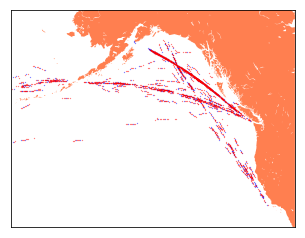

In [35]:

f = plt.figure()
clats=[]
clons=[]
clats2=[]
clons2=[]
for i in range(0,len(cpr_sample_lat)):
    tem=cpr_sample_proc[i]
    if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='Yes' :
        clats.append(cpr_sample_lat[i])
        clons.append(cpr_sample_lon[i])
    elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='No' :
        clats2.append(cpr_sample_lat[i])
        clons2.append(cpr_sample_lon[i])
map = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
#map.drawcoastlines()
#map.drawcountries()
map.fillcontinents(color = 'coral')
#map.drawmapboundary()
        #xx=cpr_sample_lon[i]
        #map.plot(xx,yy,'ko',markersize=24)
x,y = map(clons,clats)
map.plot(x, y, 'bo', markersize=.2)
x,y = map(clons2,clats2)
map.plot(x, y, 'ro', markersize=.2)
plt.show()
f.savefig("F:/data/eddy/figures/all_collocated_cpr_data.pdf", bbox_inches='tight')



In [36]:
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])


101.72 0.7691804081094831


In [37]:

f = plt.figure()
clats=[]
clons=[]
clats2=[]
clons2=[]
elats=[]
elons=[]
erads=[]
erads2=[]
espokes=[]
ecross=[]
for i in range(0,len(cpr_sample_lat)):
    tem=cpr_sample_proc[i]
    if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='Yes' :
        clats.append(cpr_sample_lat[i])
        clons.append(cpr_sample_lon[i])
        elats.append(cpr_eddy_data_lats[i])
        elons.append(cpr_eddy_data_lons2[i])
        erads.append(cpr_eddy_data_speed_radius[i])
        erads2.append(cpr_eddy_data_speed_radius_deg[i])
        ecross.append(num_cross[i])
        espokes.append(50)
    elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] and tem=='No' :
        clats2.append(cpr_sample_lat[i])
        clons2.append(cpr_sample_lon[i])
        elats.append(cpr_eddy_data_lats[i])
        elons.append(cpr_eddy_data_lons2[i])
        erads.append(cpr_eddy_data_speed_radius[i])
        erads2.append(cpr_eddy_data_speed_radius_deg[i])
        ecross.append(num_cross[i])
        espokes.append(50)      


<Figure size 432x288 with 0 Axes>

In [38]:
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])


101.72 0.7691804081094831


In [39]:
def shoot(lon, lat, azimuth, maxdist=None):
    """Shooter Function
    Original javascript on http://williams.best.vwh.net/gccalc.htm
    Translated to python by Thomas Lecocq
    """
    glat1 = lat * np.pi / 180.
    glon1 = lon * np.pi / 180.
    s = maxdist / 1.852
    faz = azimuth * np.pi / 180.
 
    EPS= 0.00000000005
    if ((np.abs(np.cos(glat1))<EPS) and not (np.abs(np.sin(faz))<EPS)):
        alert("Only N-S courses are meaningful, starting at a pole!")
 
    a=6378.13/1.852
    f=1/298.257223563
    r = 1 - f
    tu = r * np.tan(glat1)
    sf = np.sin(faz)
    cf = np.cos(faz)
    if (cf==0):
        b=0.
    else:
        b=2. * np.arctan2 (tu, cf)
 
    cu = 1. / np.sqrt(1 + tu * tu)
    su = tu * cu
    sa = cu * sf
    c2a = 1 - sa * sa
    x = 1. + np.sqrt(1. + c2a * (1. / (r * r) - 1.))
    x = (x - 2.) / x
    c = 1. - x
    c = (x * x / 4. + 1.) / c
    d = (0.375 * x * x - 1.) * x
    tu = s / (r * a * c)
    y = tu
    c = y + 1
    while (np.abs (y - c) > EPS):
 
        sy = np.sin(y)
        cy = np.cos(y)
        cz = np.cos(b + y)
        e = 2. * cz * cz - 1.
        c = y
        x = e * cy
        y = e + e - 1.
        y = (((sy * sy * 4. - 3.) * y * cz * d / 6. + x) *
              d / 4. - cz) * sy * d + tu
 
    b = cu * cy * cf - su * sy
    c = r * np.sqrt(sa * sa + b * b)
    d = su * cy + cu * sy * cf
    glat2 = (np.arctan2(d, c) + np.pi) % (2*np.pi) - np.pi
    c = cu * cy - su * sy * cf
    x = np.arctan2(sy * sf, c)
    c = ((-3. * c2a + 4.) * f + 4.) * c2a * f / 16.
    d = ((e * cy * c + cz) * sy * c + y) * sa
    glon2 = ((glon1 + x - (1. - c) * d * f + np.pi) % (2*np.pi)) - np.pi    
 
    baz = (np.arctan2(sa, b) + np.pi) % (2 * np.pi)
 
    glon2 *= 180./np.pi
    glat2 *= 180./np.pi
    baz *= 180./np.pi
 
    return (glon2, glat2, baz)
def equi(m, centerlon, centerlat, radius, *args, **kwargs):
    glon1 = centerlon
    glat1 = centerlat
    X = []
    Y = []
    for azimuth in range(0, 360):
        glon2, glat2, baz = shoot(glon1, glat1, azimuth, radius)
        X.append(glon2)
        Y.append(glat2)
    X.append(X[0])
    Y.append(Y[0])
 
    #m.plot(X,Y,**kwargs) #Should work, but doesn't...
    X,Y = m(X,Y)
    plt.plot(X,Y,**kwargs)

101.72 0.7691804081094831


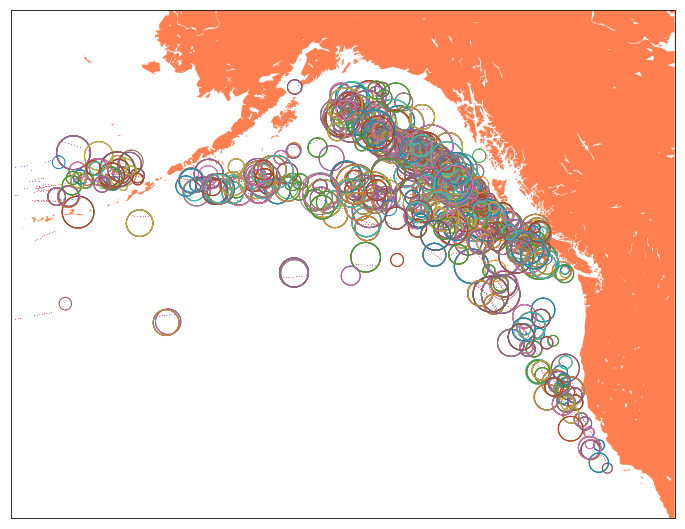

In [40]:
fig = plt.figure(figsize=(11.7,8.3))
#Custom adjust of the subplots
plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
ax = plt.subplot(111)
 
print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
#Let's create a basemap of the world
m = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
m.fillcontinents(color='coral',lake_color='white')
 
x,y = m(clons,clats)
m.plot(x, y, 'bo', markersize=.2)
x,y = m(clons2,clats2)
m.plot(x, y, 'ro', markersize=.2)

for i in range(0,len(erads)):
    centerlon = elons[i]
    centerlat = elats[i]
    radius = erads[i]
    if abs(centerlon-erads2[i])<177:
        equi(m, centerlon, centerlat, radius,lw=1.)
 
plt.savefig("F:/data/eddy/figures/all_collocated_cpr_data3.pdf",dpi=300)
 
plt.show()

In [41]:
#make a list of eddy id that have two visits
#make icheck have a 1 where trackid has more than two visits
icheck=[]
for i in range(0,len(cpr_sample_lat)):
    if num_cross[i]>1:
        itest=0
        for i2 in range(0,len(icheck)):
            if icheck[i2]==cpr_eddy_data_track_id[i]:
                itest=1
        if itest==0:
            icheck.append(cpr_eddy_data_track_id[i])
print(icheck)

[118997, 133297, 149182, 150094, 181103, 223608, 237425, 233920, 241096, 115659, 128781, 119996, 140505, 260280]


101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles118997.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles133297.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles149182.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles150094.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles181103.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles223608.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles237425.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles233920.pdf
101.72 0.7691804081094831
F:/data/eddy/figures/all_collocated_cpr_data_doubles241096.pdf


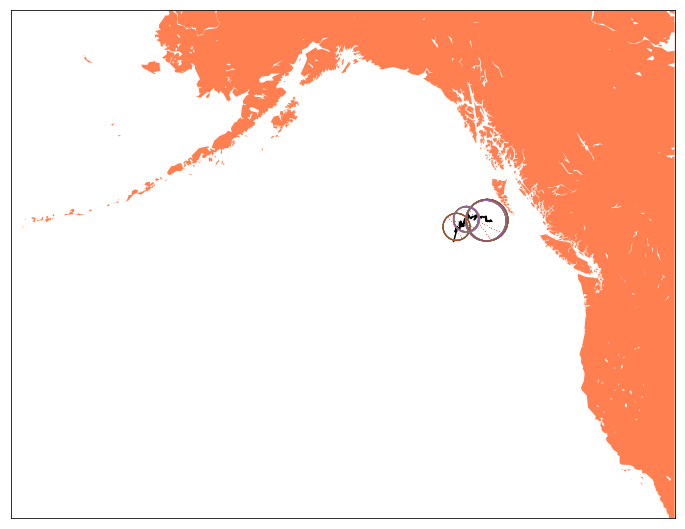

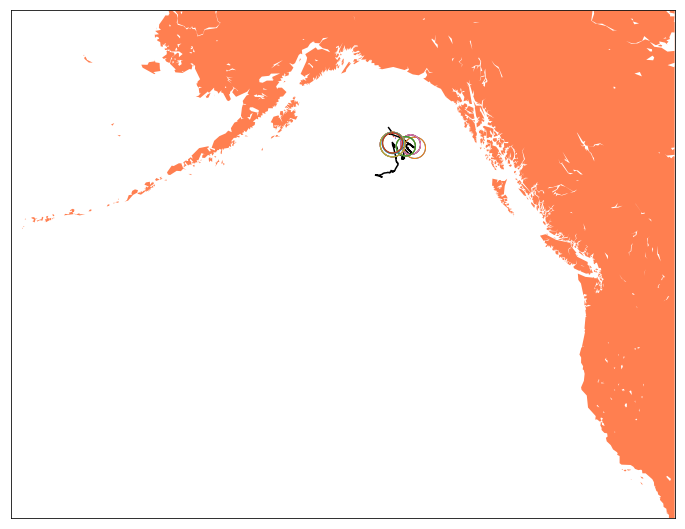

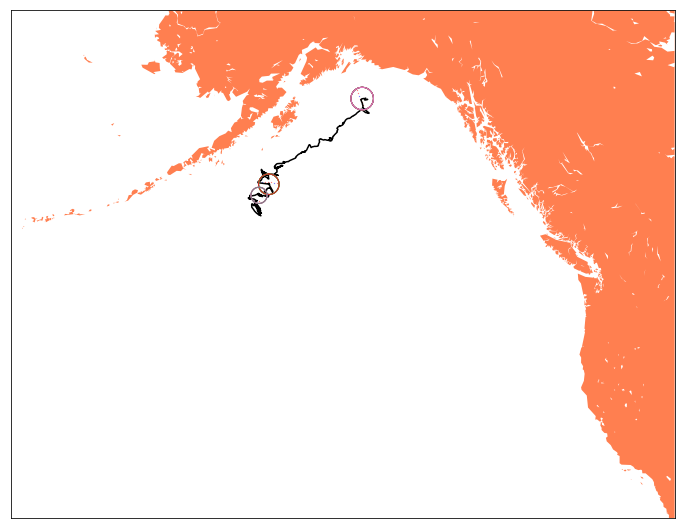

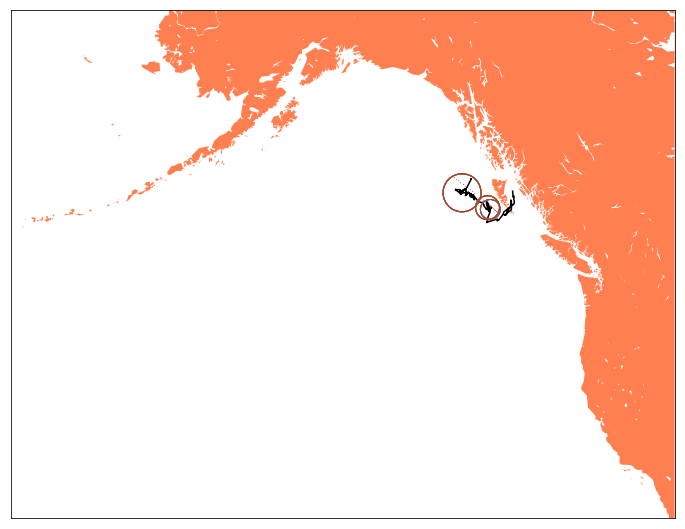

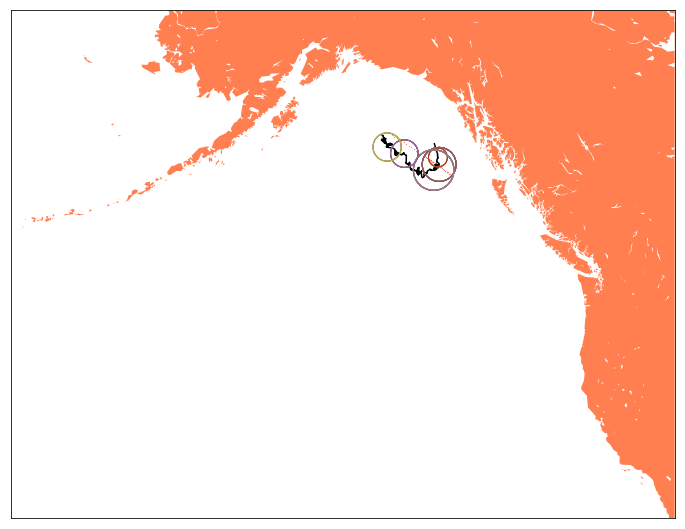

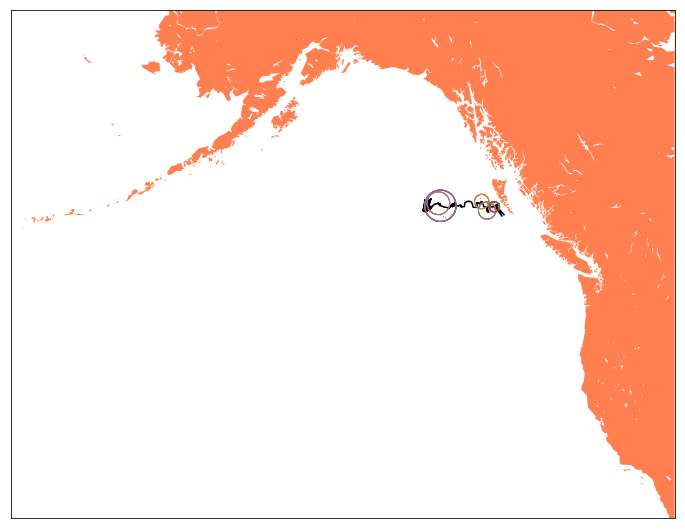

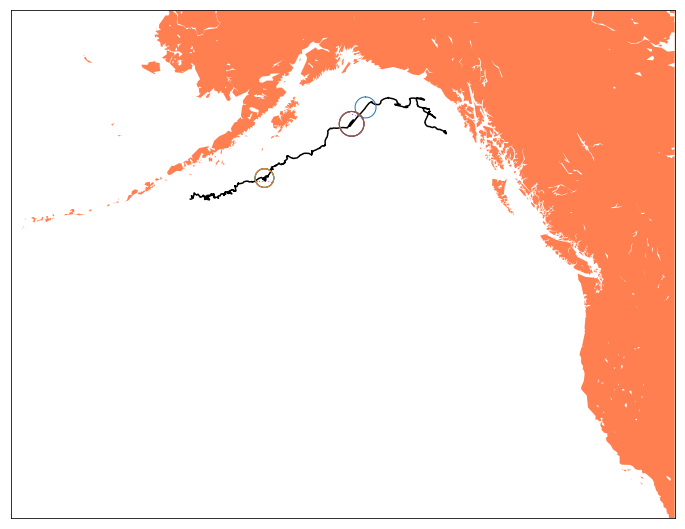

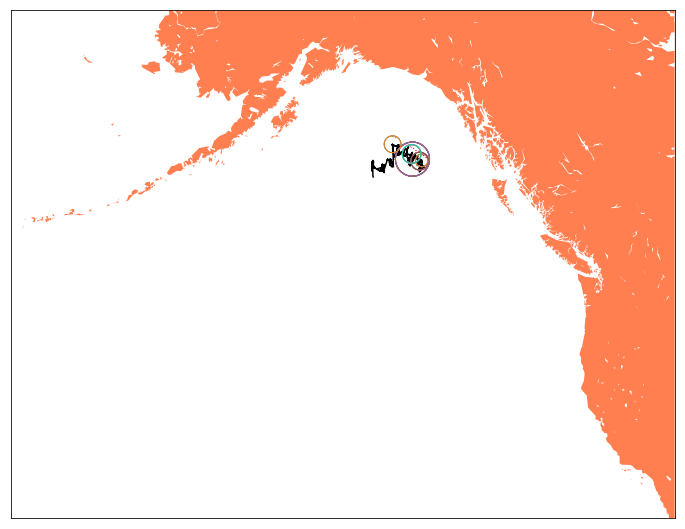

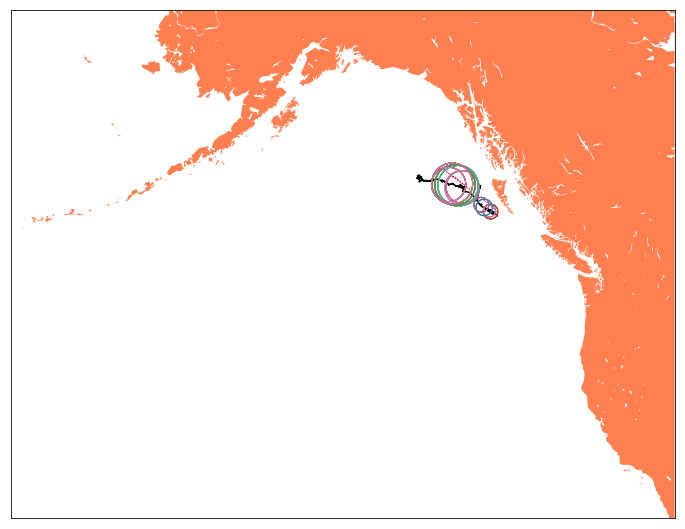

In [42]:
#now just do for eddies that have 2 visits
        
for i_tem in range(0,len(icheck)):
    tem_id=icheck[i_tem]

    #get all lat/lon for specific eddy to pring
    alats=[]
    alons=[]
    for i in range(0,len(lons_eddy)):
        if tem_id==track_eddy[i]:
            alats.append(lats_eddy[i])
            if lons_eddy[i]<=180:
                alons.append(lons_eddy[i])
            if lons_eddy[i]>180:
                alons.append(lons_eddy[i]-360)
  
    clats=[]
    clons=[]
    clats2=[]
    clons2=[]
    elats=[]
    elons=[]
    erads=[]
    erads2=[]
    for i in range(0,len(cpr_sample_lat)):
        tem=cpr_sample_proc[i]
        if cpr_sample_lon[i]>0:
            continue
        if cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] \
            and tem=='Yes' and cpr_eddy_data_track_id[i]==tem_id:
            clats.append(cpr_sample_lat[i])
            clons.append(cpr_sample_lon[i])
            elats.append(cpr_eddy_data_lats[i])
            elons.append(cpr_eddy_data_lons2[i])
            erads.append(cpr_eddy_data_speed_radius[i])
            erads2.append(cpr_eddy_data_speed_radius_deg[i])
        elif cpr_eddy_data_distance[i]<=cpr_eddy_data_radius[i] \
            and tem=='No' and cpr_eddy_data_track_id[i]==tem_id:
            clats2.append(cpr_sample_lat[i])
            clons2.append(cpr_sample_lon[i])
            elats.append(cpr_eddy_data_lats[i])
            elons.append(cpr_eddy_data_lons2[i])
            erads.append(cpr_eddy_data_speed_radius[i])
            erads2.append(cpr_eddy_data_speed_radius_deg[i])

    if len(clons2)<1 and len(clats)<1:
        continue
    fig = plt.figure(figsize=(11.7,8.3))
    #Custom adjust of the subplots
    plt.subplots_adjust(left=0.05,right=0.95,top=0.90,bottom=0.05,wspace=0.15,hspace=0.05)
    ax = plt.subplot(111)

    print(cpr_eddy_data_speed_radius[1],cpr_eddy_data_speed_radius_deg[1])
    #Let's create a basemap of the world
    m = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
                  llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
    m.fillcontinents(color='coral',lake_color='white')


    x,y = m(clons,clats)
    m.plot(x, y, 'bo', markersize=.2)
    x,y = m(clons2,clats2)
    m.plot(x, y, 'ro', markersize=.2)
    x,y = m(alons,alats)
    m.plot(x, y, 'k')

    for i in range(0,len(erads)):
        centerlon = elons[i]
        centerlat = elats[i]
        radius = erads[i]
        if abs(centerlon-erads2[i])<177:
            equi(m, centerlon, centerlat, radius,lw=1.)

 #   plt.show()
    fig_fname="F:/data/eddy/figures/all_collocated_cpr_data_doubles" + str(tem_id) + ".pdf"
    plt.savefig(fig_fname,dpi=300)
    print(fig_fname)



In [43]:
print(len(alons))
print(alons[1:200])

1109
[173.27, 173.258, 173.207, 173.179, 173.162, 173.144, 173.098, 173.057, 173.041, 172.995, 172.957, 172.923, 172.882, 172.838, 172.805, 172.763, 172.721, 172.692, 172.66, 172.612, 172.575, 172.571, 172.558, 172.542, 172.512, 172.506, 172.494, 172.486, 172.487, 172.476, 172.466, 172.461, 172.461, 172.452, 172.441, 172.44, 172.429, 172.41, 172.41, 172.404, 172.399, 172.388, 172.382, 172.375, 172.374, 172.642, 172.646, 172.632, 172.646, 172.649, 172.644, 172.63, 172.636, 172.639, 172.61, 172.585, 172.603, 172.569, 172.347, 172.321, 172.317, 172.353, 172.311, 172.395, 172.394, 172.042, 172.039, 172.033, 171.869, 171.864, 171.856, 171.842, 171.781, 171.746, 171.735, 171.725, 171.723, 171.708, 171.701, 171.701, 171.69, 171.671, 171.646, 171.625, 171.603, 171.587, 171.571, 171.549, 171.532, 171.515, 171.494, 171.474, 171.453, 171.443, 171.427, 171.404, 171.387, 171.385, 171.378, 171.37, 171.356, 171.338, 171.329, 171.317, 171.312, 171.296, 171.29, 171.293, 171.297, 171.286, 171.279, 171.2

In [44]:
    for i in range(0,len(cpr_sample_lat)):
        tem=cpr_sample_proc[i]
        if cpr_eddy_data_track_id[i]==tem_id:
            print(i,cpr_eddy_data_distance[i],cpr_eddy_data_radius[i],tem)
print('clons2',clons2)
print('clats2',clats2)
print(len(clons))
print('clons',clons)
print('clats',clats)


21093 122.71184 83.5901 No
21094 119.53483 83.5901 No
21095 119.27049 83.5901 No
21096 121.73227 83.5901 No
21097 126.96046 83.5901 No
21098 134.64078 83.5901 No
21323 115.46003 50.7991 No
21324 98.35828 50.7991 No
21325 81.83783 50.7991 No
21326 66.482216 50.7991 No
21327 53.202625 50.7991 No
21328 43.99921 50.7991 No
21329 41.51998 50.7991 No
21330 47.483307 52.2838 No
21331 59.247593 52.2838 No
21332 73.8552 52.2838 No
21333 90.02253 52.2838 No
21563 128.53061 77.1742 No
21564 121.26561 77.1742 No
21803 169.91023 95.7848 No
21804 152.28212 95.7848 No
21805 135.10083 95.7848 No
21806 118.15751 95.7848 No
21807 101.87152 95.7848 No
21808 86.563156 95.7848 No
21809 72.64101 95.7848 No
21810 61.433884 95.7848 No
21811 54.304085 95.7848 No
21812 53.125202 95.7848 No
22048 101.30639 105.356 No
22049 82.712364 105.356 No
22050 64.5074 105.356 No
22051 46.50806 105.356 No
22052 29.078806 105.356 No
22053 14.782998 105.356 No
22054 16.954544 105.356 No
22294 124.41199 94.6939 No
22295 105.94

In [45]:
filename='F:/data/eddy/collocated_data/All CPR Sample catalogue with eddy info4.nc'
ds_eddy = xr.open_dataset(filename)
ds_eddy

<xarray.Dataset>
Dimensions:                           (z: 23306)
Dimensions without coordinates: z
Data variables:
    cpr_sample_id                     (z) object ...
    cpr_sample_day                    (z) int32 ...
    cpr_sample_month                  (z) int32 ...
    cpr_sample_year                   (z) int32 ...
    cpr_sample_lat                    (z) float32 ...
    cpr_sample_lon                    (z) float32 ...
    cpr_sample_proc                   (z) |S1 ...
    cpr_eddy_data_distance            (z) float32 ...
    cpr_eddy_data_distance_from_land  (z) float32 ...
    cpr_eddy_data_radius              (z) float32 ...
    cpr_eddy_data_lons                (z) float32 ...
    cpr_eddy_data_lats                (z) float32 ...
    cpr_eddy_data_time                (z) float32 ...
    cpr_eddy_data_amplitude           (z) float32 ...
    cpr_eddy_data_speed_average       (z) float32 ...
    cpr_eddy_data_speed_radius        (z) float32 ...
    cpr_eddy_data_cyclonic_type

In [46]:
ds_eddy.cpr_sample_id[2].values
print(type(ds_eddy))

<class 'xarray.core.dataset.Dataset'>


34
<class 'xarray.core.dataset.Dataset'>


C:\Users\gentemann\Anaconda3\lib\site-packages\ipykernel_launcher.py:8: FutureWarning: calling len() on an xarray.Dataset will change in xarray v0.11 to only include data variables, not coordinates. Call len() on the Dataset.variables property instead, like ``len(ds.variables)``, to preserve existing behavior in a forwards compatible manner.
  


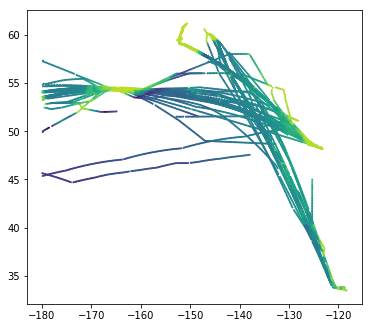

In [47]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
#f = plt.figure()
#map = Basemap(projection='merc', lat_0 = 45, lon_0 = -130,    resolution = 'l', area_thresh = 0.1,    
#              llcrnrlon=-180.25, llcrnrlat=30.0,urcrnrlon=-115.25, urcrnrlat=62.75)
#map.fillcontinents(color = 'coral')
#x,y = map(ds_eddy.cpr_sample_lon.values,ds_eddy.cpr_sample_lat.values)
d2=ds_eddy.where(ds_eddy.cpr_sample_lon<0)
print(len(d2))
print(type(d2))
ax1.scatter(d2.cpr_sample_lon.values,d2.cpr_sample_lat.values, c = cpr_sample_depth_exact,s=1)
#plt.scatter(ds_eddy.cpr_sample_lon.values,ds_eddy.cpr_sample_lat.values, c = ds_eddy.cpr_sample_ETOPO_depth.values)
#plt.plot(ds_eddy.cpr_sample_lon.values[0:1000],ds_eddy.cpr_sample_ETOPO_depth.values[0:1000],'.')
plt.show()
f.savefig('F:/data/eddy/collocated_data/depth_image.png', transparent=False, format='png')


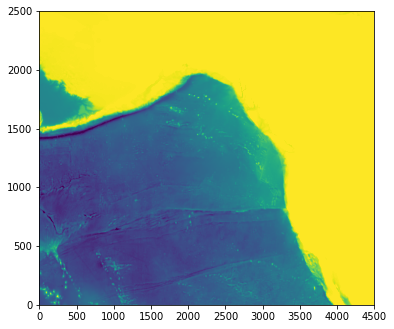

In [48]:
fig, (ax1) = plt.subplots(nrows=1, figsize=(6, 5.4))
im = ax1.imshow(ds_topo.z[7000:9500,0:4500], interpolation='bilinear',vmin=-7000.0, vmax=1.0,aspect='auto',origin='lower')
plt.show()


In [49]:
ds_eddy.cpr_sample_ETOPO_depth.values[0:10]

array([ -821.,  -556.,  -445.,  -515.,  -815., -1264., -1132., -1059.,
       -1085., -1859.], dtype=float32)

In [50]:
ds_eddy.cpr_sample_id[0:1000]

<xarray.DataArray 'cpr_sample_id' (z: 1000)>
array(['5AC1', '5AC2', '5AC3', ..., '31AC1', '31AC2', '31AC3'], dtype=object)
Dimensions without coordinates: z